<a href="https://colab.research.google.com/github/NarayaniSuresh/pinnaclelabs/blob/main/AI_HR_RESUME_PARSER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [ ]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

In [ ]:
# Merge datasets for feature integration
train = train.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
train = train.merge(stores, on='Store', how='left')
test = test.merge(features, on=['Store', 'Date', 'IsHoliday'], how='left')
test = test.merge(stores, on='Store', how='left')


In [ ]:
# Convert 'Date' column to datetime format
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [ ]:
# Feature engineering: Extract time-related features
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Week'] = train['Date'].dt.isocalendar().week
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].dt.isocalendar().week

In [ ]:
# Feature engineering: Holiday scaling
holidays = {
    'Super Bowl': ['12-Feb-10', '11-Feb-11', '10-Feb-12', '8-Feb-13'],
    'Labor Day': ['10-Sep-10', '9-Sep-11', '7-Sep-12', '6-Sep-13'],
    'Thanksgiving': ['26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13'],
    'Christmas': ['31-Dec-10', '30-Dec-11', '28-Dec-12', '27-Dec-13']
}

In [ ]:
for holiday, dates in holidays.items():
    for date in dates:
        train.loc[train['Date'] == pd.to_datetime(date), 'IsHoliday'] = True
        test.loc[test['Date'] == pd.to_datetime(date), 'IsHoliday'] = True


In [ ]:
# Fill missing markdown values with 0 (no promotion)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train[markdown_cols] = train[markdown_cols].fillna(0)
test[markdown_cols] = test[markdown_cols].fillna(0)

In [ ]:
# Feature engineering: Lag features for past weekly sales
for lag in [1, 2, 3]:
    train[f'Weekly_Sales_Lag_{lag}'] = train.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(lag)


In [ ]:
# Fill missing lag features with the median sales
train[['Weekly_Sales_Lag_1', 'Weekly_Sales_Lag_2', 'Weekly_Sales_Lag_3']] = \
    train[['Weekly_Sales_Lag_1', 'Weekly_Sales_Lag_2', 'Weekly_Sales_Lag_3']].fillna(train['Weekly_Sales'].median())

In [ ]:
# Drop rows where lag features could not be created
train = train.dropna()

In [ ]:
# Define features for training
features_cols = ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday',
                 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Year', 'Month', 'Week',
                 'Weekly_Sales_Lag_1', 'Weekly_Sales_Lag_2', 'Weekly_Sales_Lag_3']

In [ ]:
# Define target
X = train[features_cols]
y = train['Weekly_Sales']


In [ ]:

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# XGBoost model setup
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)



In [ ]:
# Model training
xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predictions on validation set
y_val_pred = xgb_model.predict(X_val)



In [ ]:
# Evaluate performance (WMAE)
def weighted_mae(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday, 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

val_wmae = weighted_mae(y_val, y_val_pred, X_val['IsHoliday'])
print(f"Validation WMAE: {val_wmae}")



Validation WMAE: 2146.1437066967596


In [ ]:
# Generate lag features for test set using median values from the training set
def create_lag_features(df, dept_median_sales):
    df['Weekly_Sales_Lag_1'] = df['Dept'].map(dept_median_sales)
    df['Weekly_Sales_Lag_2'] = df['Dept'].map(dept_median_sales)
    df['Weekly_Sales_Lag_3'] = df['Dept'].map(dept_median_sales)
    return df

# Generate department median sales from the training set
dept_median_sales = train.groupby('Dept')['Weekly_Sales'].median()

# Apply the lag feature creation for the test set
test = create_lag_features(test, dept_median_sales)

# Ensure that both train and test datasets have the same features
features_cols = ['Store', 'Dept', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday',
                 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Year', 'Month', 'Week',
                 'Weekly_Sales_Lag_1', 'Weekly_Sales_Lag_2', 'Weekly_Sales_Lag_3']

# Define X_test after aligning the columns
X_test = test[features_cols]

# Make predictions on the test set
y_test_pred = xgb_model.predict(X_test)

# Prepare the submission file
test['Weekly_Sales'] = y_test_pred
submission = test[['Store', 'Dept', 'Date', 'Weekly_Sales']]
submission.to_csv('submission.csv', index=False)


In [40]:
# Save submission file for download
submission_file_path = "/content/submissions.csv"
submission.to_csv(submission_file_path, index=False)

submission_file_path  # Output the path for download


'/content/submissions.csv'

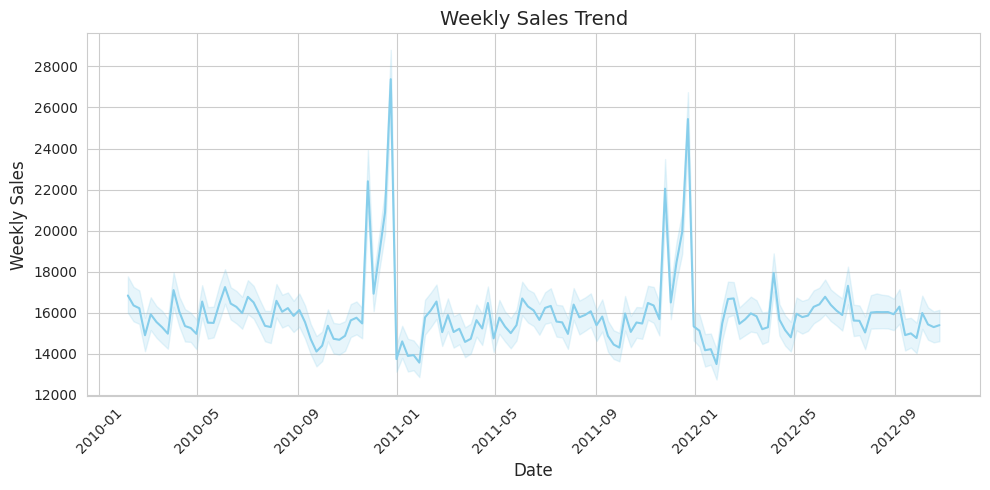

<ipython-input-44-5d5a8f95e495>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Store', y='Weekly_Sales', data=train, palette="pastel")


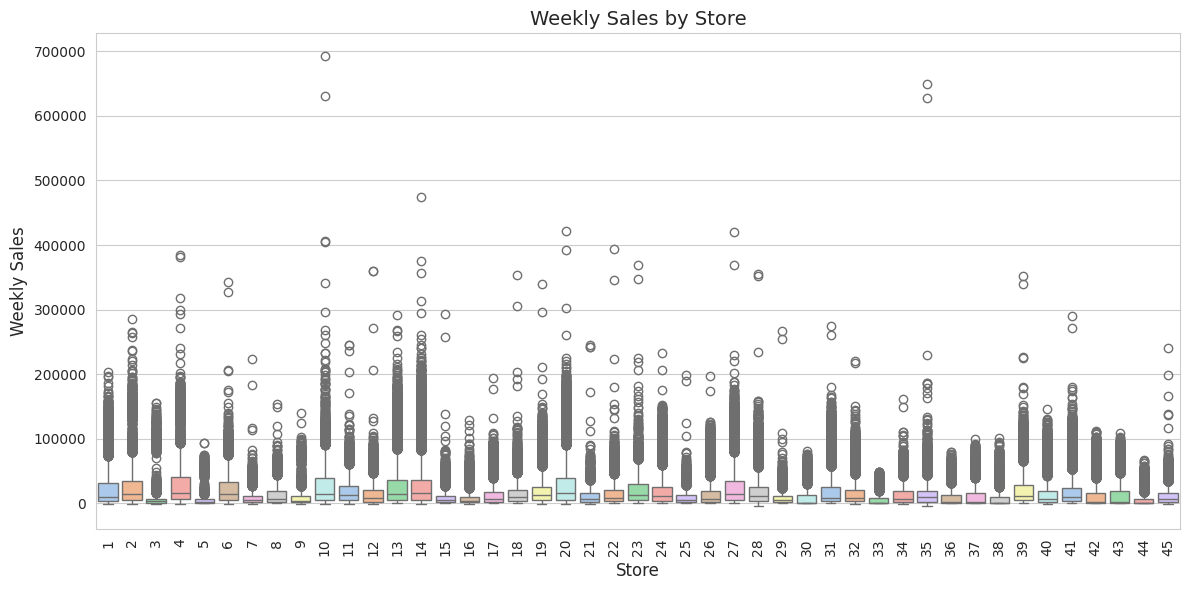

<ipython-input-44-5d5a8f95e495>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dept', y='Weekly_Sales', data=train, palette="Set3")


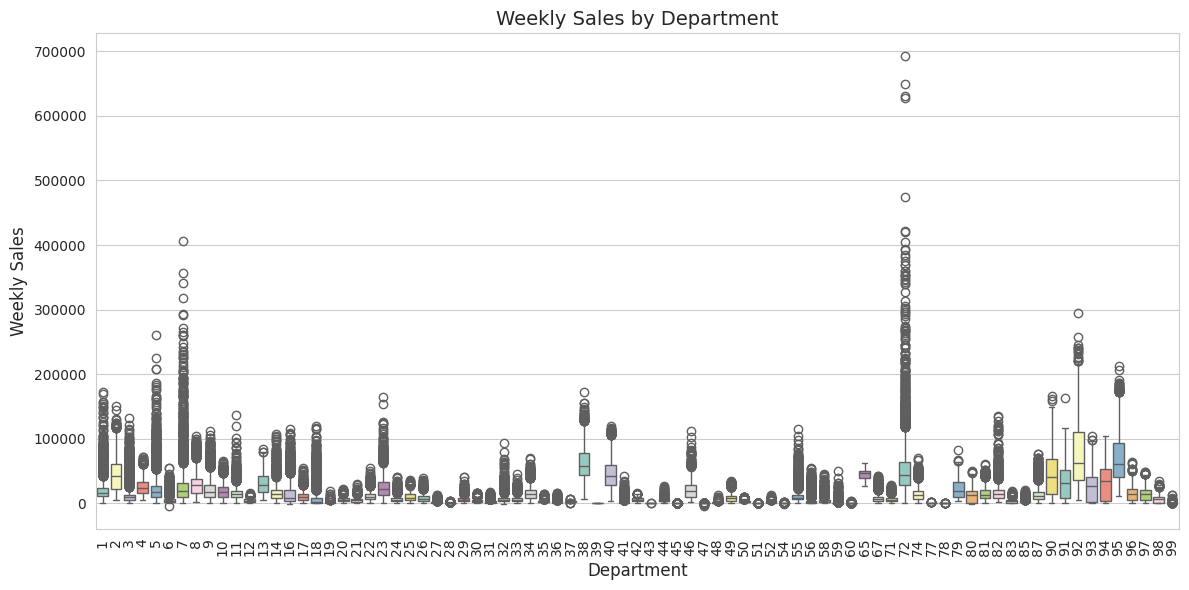

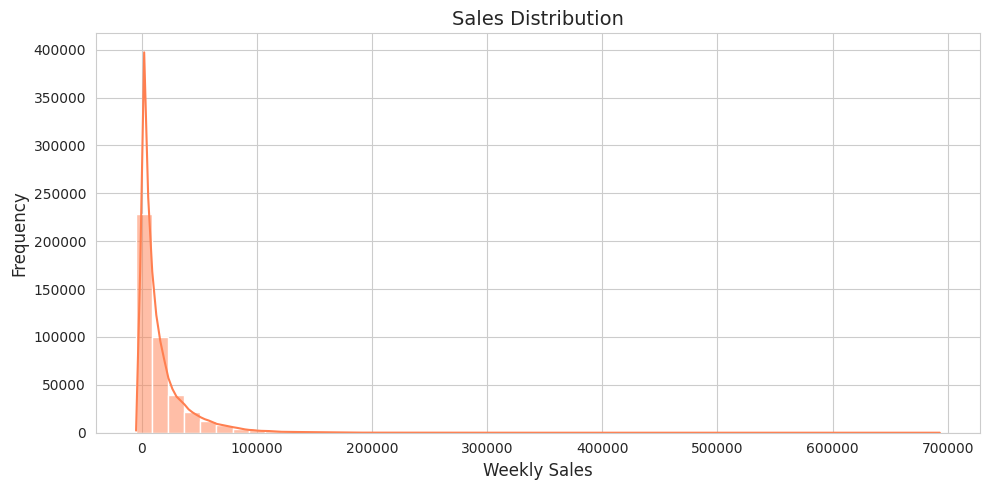

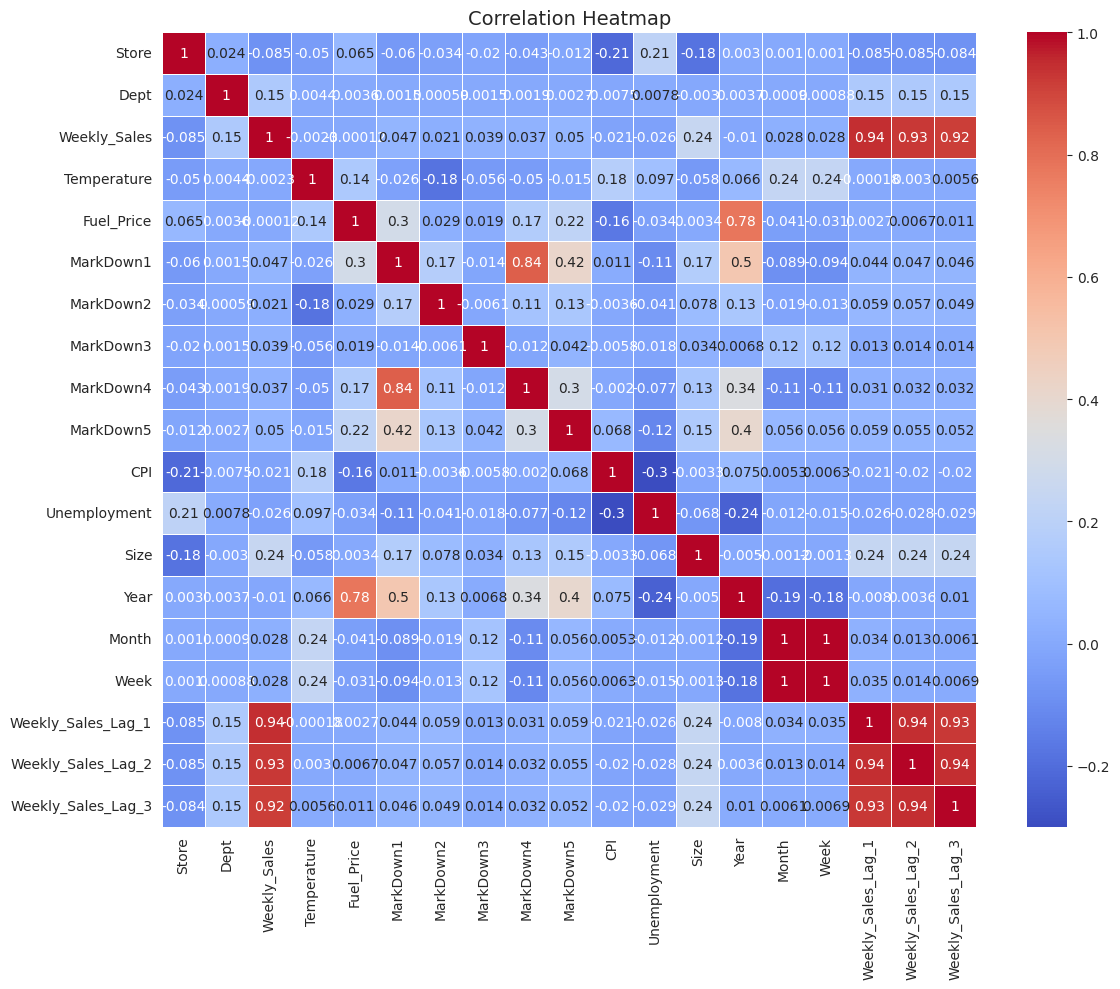

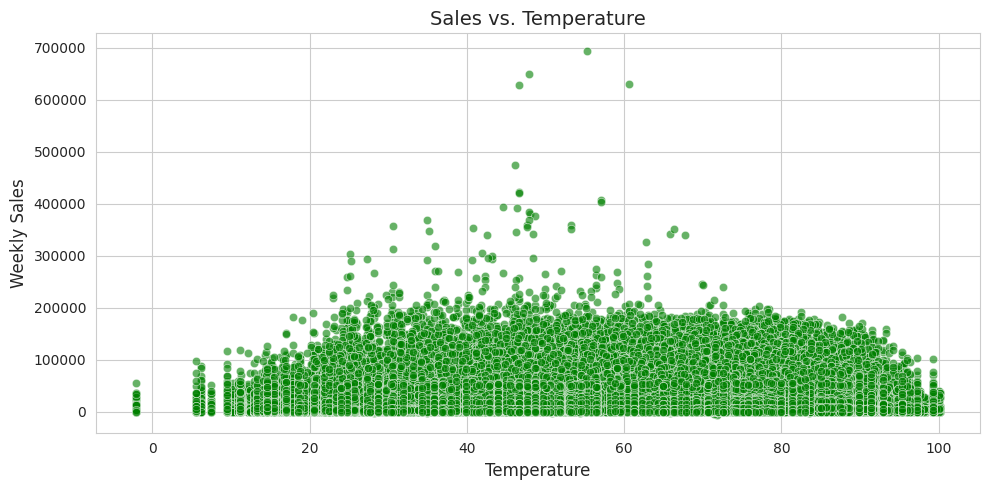

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style for the plots
sns.set_style("whitegrid")

# Weekly Sales Trend
plt.figure(figsize=(10, 5))
sns.lineplot(x='Date', y='Weekly_Sales', data=train, color='skyblue')
plt.title('Weekly Sales Trend', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weekly Sales', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

# Weekly Sales by Store
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=train, palette="pastel")
plt.title('Weekly Sales by Store', fontsize=14)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Weekly Sales', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Weekly Sales by Department
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dept', y='Weekly_Sales', data=train, palette="Set3")
plt.title('Weekly Sales by Department', fontsize=14)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Weekly Sales', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Sales Distribution
plt.figure(figsize=(10, 5))
sns.histplot(train['Weekly_Sales'], bins=50, kde=True, color='coral')
plt.title('Sales Distribution', fontsize=14)
plt.xlabel('Weekly Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
numerical_features = train.select_dtypes(include=np.number).columns
correlation_matrix = train[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

# Sales vs. Temperature
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=train, color='green', alpha=0.6)
plt.title('Sales vs. Temperature', fontsize=14)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Weekly Sales', fontsize=12)
plt.tight_layout()
plt.show()